In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost  as xgb

from sklearn.linear_model   import LinearRegression
from sklearn.ensemble       import RandomForestRegressor
from sklearn.neighbors      import KNeighborsRegressor

from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster
from sktime.forecasting.arima               import ARIMA, AutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster, make_reduction
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender

from sktime.transformations.series.boxcox       import LogTransformer, BoxCoxTransformer
from sktime.transformations.series.exponent     import ExponentTransformer
from sktime.transformations.series.difference   import Differencer
from sktime.transformations.series.lag          import Lag

In [36]:
# Set parameters for generating data
params = {'a': 0.4, 'b': 1, 'c': 10, 'w': 10, 'n': 365}

# number of datapoints
n = 365

# Generate the data
def generateData(x,params, n):
    return params['a']*x*np.sin(params['w']*x) + params['b']*x + params['c'] + np.random.normal(0, 0.5, n)

x = np.linspace(0, 10, n)
y = generateData(x,params,n)

# Generate the timestamps for a year of data
timestamps = pd.date_range(start='2020-01-01', periods=n, freq='D')

# Create the DataFrame
train = pd.DataFrame({'y': y}, index=timestamps)

# set forecasting horizon for the next year
fh = ForecastingHorizon(pd.date_range(train.index[-1]+pd.Timedelta(days=1), periods=365, freq="D"), is_relative=False)

In [37]:
#decent model for noisey data
forecaster = TransformedTargetForecaster(
                                        [   
                                        ("transformer", Differencer(lags=[1])),
                                        ("forecast", make_reduction(LinearRegression(),window_length=18,strategy="recursive"))
                                        ]
                                        )


# forecaster = TransformedTargetForecaster(
#                                         [   
#                                              ("transformer", Differencer(lags=[1])),
#                                         #    ("detrend",     Detrender(PolynomialTrendForecaster(degree=1))),
#                                         #    ("transformer", LogTransformer(offset=10)),
#                                         #    ("transformer", ExponentTransformer(power=0.5)),
#                                         #    ("transformer", BoxCoxTransformer()),
#                                              ("forecast", make_reduction(LinearRegression(),window_length=18,strategy="recursive"))
#                                         #    ("forecast", make_reduction(xgb.XGBRegressor(),window_length=10,strategy="recursive"))
#                                         ]
#                                         )


forecaster.fit(train)
y_pred = forecaster.predict(fh)


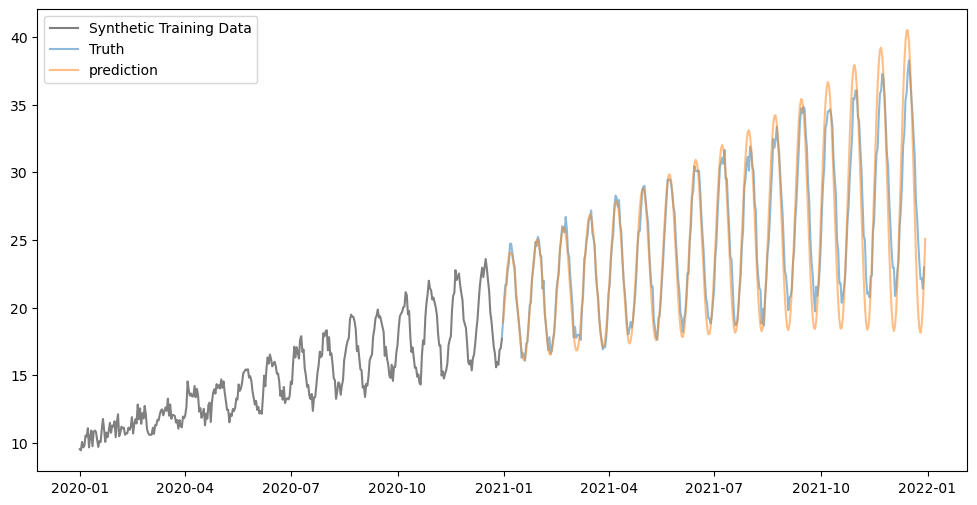

In [39]:

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(train, color='grey', label="Synthetic Training Data")
#plt.plot(forecaster.transform(train), label="Transformed Training Data")
plt.plot(pd.date_range(start=timestamps[-1], periods=n, freq='D'), generateData(np.linspace(10, 20, n),params,n), label="Truth", alpha=0.5)
plt.plot(y_pred,label="prediction", alpha=0.5)
plt.legend()
plt.show()

Learnings:  
- Treebased models can return forcast outside of the training data range when feature engineering is added. Without feature engineering, they can't. 

- Treebased models are terrible without proper feature engineering! Much worse than linear models.
 
        - I haven't found a way to fix the problem of increasing amplitude. 
                --> Maybe it is not possible due to treebased models not being able to extrapolate. (Treebased models can only interpolate.)
        
- LinearRegression looks much better in this case. 